In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from careamics import Configuration, CAREamist

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/CalciumImagingDenoising/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cupy Available= 1


# Noise2Noise Training
Let's try out some pupolar SOTA denoisers. In this experiment I will rely of [*CAREamics*](https://careamics.github.io) implementation, that is built with *PyThorch*, in contrast to the original [*Noise2Noise*](https://github.com/NVlabs/noise2noise), which uses *TensorFlow*.

In [ ]:
WORK_DIR=Path("n2n")
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, gt = (Recording(_, max_frames=60) for _ in [x_path, gt_path])

In [3]:
x_mean, gt_mean = (np.mean(_.np) for _ in [x, gt])
x_std, gt_std = (np.std(_.np) for _ in [x, gt])

In [ ]:
config_dict = {
    "experiment_name": "N2N_synthetic",
    "algorithm_config": {
        "algorithm": "n2n",
        "loss": "mse",
        "model": {
            "architecture": "UNet",
            # "num_channels":[64, 128, 256],
        },
    },
    "training_config": {
        "batch_size": 16,
        "num_epochs":10,
        # "learning_rate": 0.0004,
    },
    "data_config": {
        "data_type": "array",
        "axes": "ZYX",
        "patch_size": [32,128, 128],  # Noise2Void doesnt exploit temporal dim
        "image_means":[gt_mean],
        "image_stds":[gt_std],
    },
}
cfg = Configuration(**config_dict)

In [ ]:
engine = CAREamist(cfg, work_dir=WORK_DIR)
cprint("cyan:Starting N2V training...")
history = engine.train(train_source=x.np, train_target=gt.np)

In [ ]:
engine = CAREamist(WORK_DIR / "checkpoints/N2N_synthetic-v2.ckpt")
y = engine.predict(x.np[:32, :244, :244])
y = y[0].squeeze().squeeze()

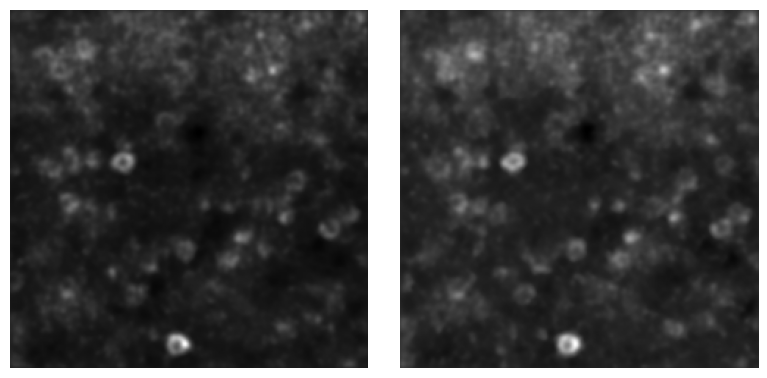

In [10]:
imshow([y[i] for i in [0,-1]])

In [ ]:
Recording(y[:60]).render("n2v.mp4", codec="libx264")

## Metric plotting

In [ ]:
experiment="n2n_synthetic_frames6000_t32_ep10"

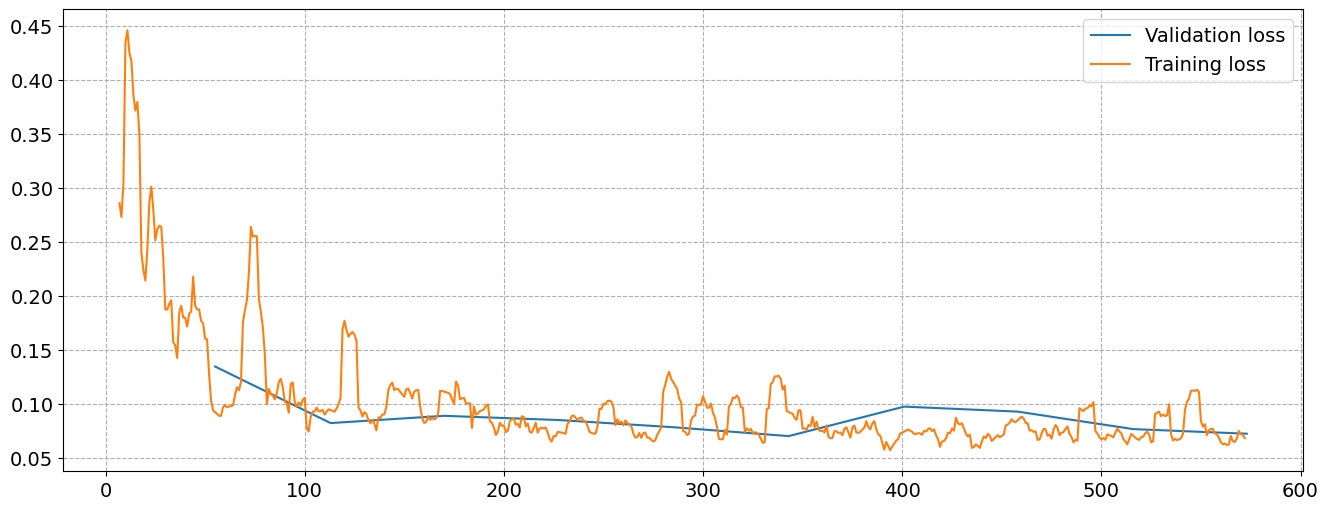

In [ ]:
df = pd.read_csv(f"n2n/csv_logs/{experiment}/version_0/metrics.csv")
ax = df["val_loss"].dropna().plot(figsize=(16, 6), label="Validation loss")
df["train_loss_step"].dropna().rolling(window=8).mean().plot(label="Training loss", ax=ax)
ax.legend()